In [1]:
### Evaluate the different MOFA models from E4 tested with different amount of factors and compare the effect

#############################################
# Prerequisites - Load Libraries

In [2]:
source('MS0_Libraries.r')

In [13]:
source('MS4_Plot_Config.r')

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


###############################################
# Preqrequisites Configurations & Parameters

In [14]:
data_path = '../data/current'

In [15]:
result_path = '../results/current'

In [16]:
name = 'V_FINAL_INTEGRATED'  # name of dataset to load

# Load Data 

## MOFA Models

In [17]:
num_factors = c(5,10,15,20,25) # define number of factors

In [18]:
model_list = list()

In [19]:
for(i in num_factors){
    model_name = paste0("MOFA_MODEL_FACTOR_TEST_", name, '-', 'FALSE' , i ,'.hdf5') # added number of factors in review to test different 
    outfile = file.path( paste0(result_path, '/E-Analysis/',  model_name) )
    model_list[[as.character(i)]] <- load_model(outfile, verbose = TRUE)
    }

Loading data...

Loading expectations for 2 nodes...

Loading model options...

Loading training options and statistics...

Assigning names to the different dimensions...

Re-ordering factors by their variance explained...

Doing quality control...

Checking views names...

Checking groups names...

Checking samples names...

Checking features names...

Checking dimensions...

Checking there are no features with complete missing values...

Checking sample covariates...

Checking expectations...

Checking for intercept factors...

Checking for highly correlated factors...

Loading data...

Loading expectations for 2 nodes...

Loading model options...

Loading training options and statistics...

Assigning names to the different dimensions...

Re-ordering factors by their variance explained...

Doing quality control...

Checking views names...

Checking groups names...

Checking samples names...

Checking features names...

Checking dimensions...

Checking there are no features with compl

In [20]:
#str(model_list)

## Prepared combined data (input data for MOFA model)

In [22]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',name,'.csv')
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "2023-10-06 16:38:54 UTC"


In [23]:
data_long$X = NULL

## Sample Data (information about patients)

In [24]:
sample_data = read.csv(paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv'))

In [26]:
sample_data$CK_raw = sample_data$CK

In [27]:
sample_data$CK = log2(sample_data$CK+1)

In [28]:
sample_data$Troponin = log2(sample_data$Troponin+1)

In [29]:
sample_data$CK_MB = log2(as.numeric(sample_data$CK_MB)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [30]:
sample_data$CRP =  log2(as.numeric(sample_data$CRP)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [31]:
sample_data$sample_id[(sample_data$sample_id == 'm13.2')  & (sample_data$library %in%  c('L6'))] = 'm13.22'

In [32]:
sample_data$sample_id[(sample_data$sample_id == 'm6.4')  & (sample_data$library %in%  c('L10'))] = 'm6.42'

In [33]:
sample_data$sample_id[(sample_data$sample_id == 'm6.1')  & (sample_data$library %in%  c('L3'))] = 'm6.12'

## Prepare data list

In [34]:
length(unique(data_long$sample_id))

[1] 128

In [35]:
final_data_long_backup = data_long

In [36]:
final_data_long = final_data_long_backup

In [37]:
final_data_long$cell_type = NULL

In [38]:
final_data_long$variable_transformed = NULL

In [39]:
final_data_long$type[ final_data_long$type == 'single_cell'] = str_extract(final_data_long$variable[ final_data_long$type == 'single_cell'] , '.*__')

In [40]:
final_data_long$config = NULL

In [41]:
final_data_long$X = NULL

In [45]:
### Filter only samples measured across multiple TPs

In [46]:
samples = unique(final_data_long$sample_id)

In [47]:
unique(final_data_long$type)

[1] "clinical_data"                 "cytokine"                     
 [3] "neutrophil"                    "proteomics"                   
 [5] "X0_T.cell.CD4__"               "X1_T.cell.CD8__"              
 [7] "X10_B.cell__"                  "X11_T.cell.CD4__"             
 [9] "X12_Monocytes...CD16_FCGR3A__" "X13_Dendritic__"              
[11] "X2_T.cell.CD4__"               "X3_NK__"                      
[13] "X4_Monocytes...CD14__"         "X5_T.cell.CD4__"              
[15] "X6_Monocytes...CD14__"         "X7_Monocytes...CD14__"        
[17] "X8_B.cell__"                   "X9_Monocytes...CD16_FCGR3A__"

In [48]:
length(samples)

[1] 128

In [49]:
### Prepare data list for MOFA

In [50]:
data_list = list()

In [53]:
nrow(final_data_long)

[1] 1700096

In [54]:
nrow(final_data_long)

[1] 1700096

In [56]:
data_list= list()

In [57]:
for(i in unique(final_data_long$type)){
    data = final_data_long[final_data_long$type == i, ]
    
    data$type = NULL
    data$cell_type = NULL
    
    data = data %>% dcast(variable ~ sample_id, value  = "value")
    rownames(data) = data$variable
    colnames(data) = str_replace(colnames(data), 'value\\.', '')
    data$variable = NULL
    
    data[setdiff( samples, names(data))] = NA  # use all samples
    
    data = data[,order(colnames(data))]
    data = data[,colnames(data) %in% samples]
    
    data_list[[i]] = as.matrix(data)
    }

Warning message in dcast(., variable ~ sample_id, value = "value"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error.”
Warning message in dcast(., variable ~ sample_id, value = "value"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error.”
Warning message in dcast(., variable ~ sample_id, value = "value"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecat

In [58]:
dim(data)

[1] 872 128

In [59]:
#str(data_list)

## Create MOFA object

### Create for own data and train

In [61]:
names(data_list) = str_replace_all(names(data_list) , '__|\\.|\\.\\.|\\.\\.\\.', '')

In [62]:
data_list_orig = data_list

In [63]:
## Adjustments for plotting overview

In [64]:
names(data_list) = str_replace(names(data_list), 'X0_TcellCD4', 'CD4+ T cells (Cluster 0)')
names(data_list) = str_replace(names(data_list), 'clinical_data', 'Clinical')
names(data_list) = str_replace(names(data_list), 'X1_TcellCD8', 'CD8+ T cells (Cluster 1)')
names(data_list) = str_replace(names(data_list), 'X10_Bcell', 'B cells (Cluster 10)')
names(data_list) = str_replace(names(data_list), 'X11_TcellCD4', 'CD4+ T cells (Cluster 11)')
names(data_list) = str_replace(names(data_list), 'X12_MonocytesCD16_FCGR3A', 'FCGR3A(high) Monocytes (Cluster 12)')
names(data_list) = str_replace(names(data_list), 'X13_Dendritic', 'Dendritic cells (Cluster 13)')
names(data_list) = str_replace(names(data_list), 'X2_TcellCD4', 'CD4+ T cells (Cluster 2)')
names(data_list) = str_replace(names(data_list), 'X3_NK', 'NK cells (Cluster 3)')
names(data_list) = str_replace(names(data_list), 'X4_MonocytesCD14', 'CD14(high) Monocytes (Cluster 4)')
names(data_list) = str_replace(names(data_list), 'X5_TcellCD4', 'CD4+ T cells (Cluster 5)')
names(data_list) = str_replace(names(data_list), 'X6_MonocytesCD14', 'CD14(high) Monocytes (Cluster 6)')
names(data_list) = str_replace(names(data_list), 'X7_MonocytesCD14', 'CD14(high) Monocytes (Cluster 7)')
names(data_list) = str_replace(names(data_list), 'X8_Bcell','B cells (Cluster 8)')
names(data_list) = str_replace(names(data_list), 'X9_MonocytesCD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')


names(data_list) = str_replace(names(data_list), 'clinical','Clinical')
names(data_list) = str_replace(names(data_list), 'cytokine','Cytokine')
names(data_list) = str_replace(names(data_list), 'neutrophil','Neutrophil')
names(data_list) = str_replace(names(data_list), 'proteomics','Proteomics')

In [65]:
names(data_list)

[1] "Clinical"                            "Cytokine"                           
 [3] "Neutrophil"                          "Proteomics"                         
 [5] "CD4+ T cells (Cluster 0)"            "CD8+ T cells (Cluster 1)"           
 [7] "B cells (Cluster 10)"                "CD4+ T cells (Cluster 11)"          
 [9] "FCGR3A(high) Monocytes (Cluster 12)" "Dendritic cells (Cluster 13)"       
[11] "CD4+ T cells (Cluster 2)"            "NK cells (Cluster 3)"               
[13] "CD14(high) Monocytes (Cluster 4)"    "CD4+ T cells (Cluster 5)"           
[15] "CD14(high) Monocytes (Cluster 6)"    "CD14(high) Monocytes (Cluster 7)"   
[17] "B cells (Cluster 8)"                 "FCGR3A(high) Monocytes (Cluster 9)"

In [67]:
#str(data_list)

In [68]:

MOFAobject = create_mofa(data_list)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




In [69]:
### Plot Data Overview

In [70]:
options(repr.plot.width=30, repr.plot.height=10)
mofa_overview = plot_data_overview(MOFAobject)

In [71]:
length(unique(data_long$variable))

[1] 13282

In [72]:
mofa_overview = mofa_overview + plot_config +cell_type_colors + theme(axis.text.x = element_blank())

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


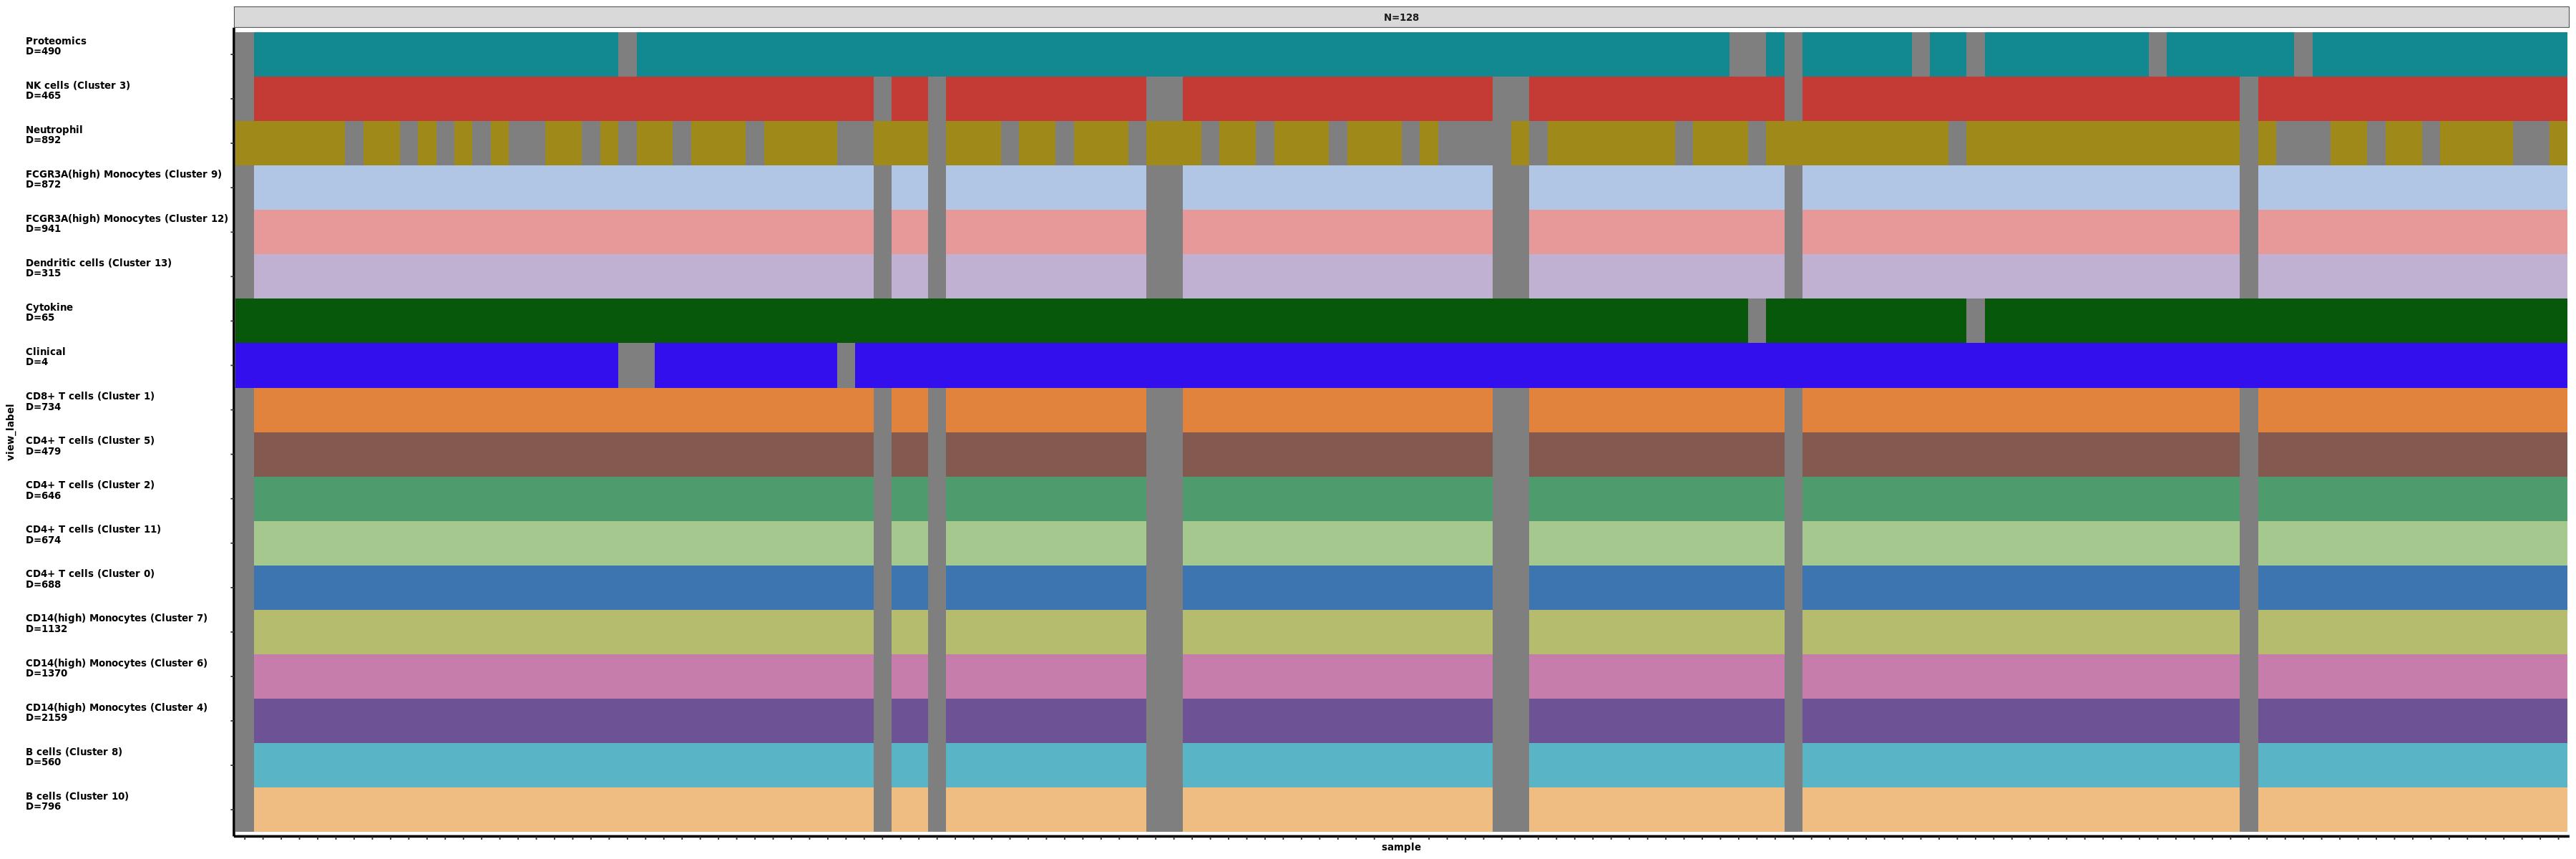

In [73]:
mofa_overview

In [74]:
### Use orig MOFA object

In [75]:
MOFAobject = create_mofa(data_list_orig)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




# Downstream Analysis of generated models

## Compare total explained variance

In [76]:
lapply(model_list, function(x){
    mean(x@cache$variance_explained$r2_total[[1]])
    })
### 20 Factor model used: 35.7461964551804   

$`5`
[1] 19.25362

$`10`
[1] 26.69727

$`15`
[1] 31.71338

$`20`
[1] 35.7462

$`25`
[1] 38.45252

In [77]:
### compare explained variance per view

In [78]:
var_explained_per_view = lapply(model_list, function(x){
    x@cache[["variance_explained"]]$r2_total
    })

In [79]:
var_explained_per_view_data = data.frame()

for(i in names(var_explained_per_view)){
    data = var_explained_per_view[[i]]$group1
    data = as.data.frame(data)
    data$view = rownames(data)
    data$amount_factors = i
    
    var_explained_per_view_data = rbind(data, var_explained_per_view_data)
    }

In [80]:
head(var_explained_per_view_data,2)

,data,view,amount_factors
,<dbl>,<chr>,<chr>
clinical_data,60.21838,clinical_data,25
cytokine,26.59534,cytokine,25


In [81]:
unique(var_explained_per_view_data$amount_factors)

[1] "25" "20" "15" "10" "5"

In [82]:
figure_name = paste0("SUPP10_E5_Variance_Amount_Factors")

In [83]:
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'X0_TcellCD4', 'CD4+ T cells (Cluster 0)')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'clinical_data', 'Clinical')
var_explained_per_view_data$view= str_replace(var_explained_per_view_data$view, 'X1_TcellCD8', 'CD8+ T cells (Cluster 1)')
var_explained_per_view_data$view= str_replace(var_explained_per_view_data$view, 'X10_Bcell', 'B cells (Cluster 10)')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'X11_TcellCD4', 'CD4+ T cells (Cluster 11)')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'X12_MonocytesCD16_FCGR3A', 'FCGR3A(high) Monocytes (Cluster 12)')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'X13_Dendritic', 'Dendritic cells (Cluster 13)')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'X2_TcellCD4', 'CD4+ T cells (Cluster 2)')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'X3_NK', 'NK cells (Cluster 3)')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'X4_MonocytesCD14', 'CD14(high) Monocytes (Cluster 4)')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'X5_TcellCD4', 'CD4+ T cells (Cluster 5)')
var_explained_per_view_data$view= str_replace(var_explained_per_view_data$view, 'X6_MonocytesCD14', 'CD14(high) Monocytes (Cluster 6)')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'X7_MonocytesCD14', 'CD14(high) Monocytes (Cluster 7)')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'X8_Bcell','B cells (Cluster 8)')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'X9_MonocytesCD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')


var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'clinical','Clinical')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'cytokine','Cytokine')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'neutrophil','Neutrophil')
var_explained_per_view_data$view = str_replace(var_explained_per_view_data$view, 'proteomics','Proteomics')

In [84]:
# Sizes of the plot
width_par = 6
height_par =4

png 
  2

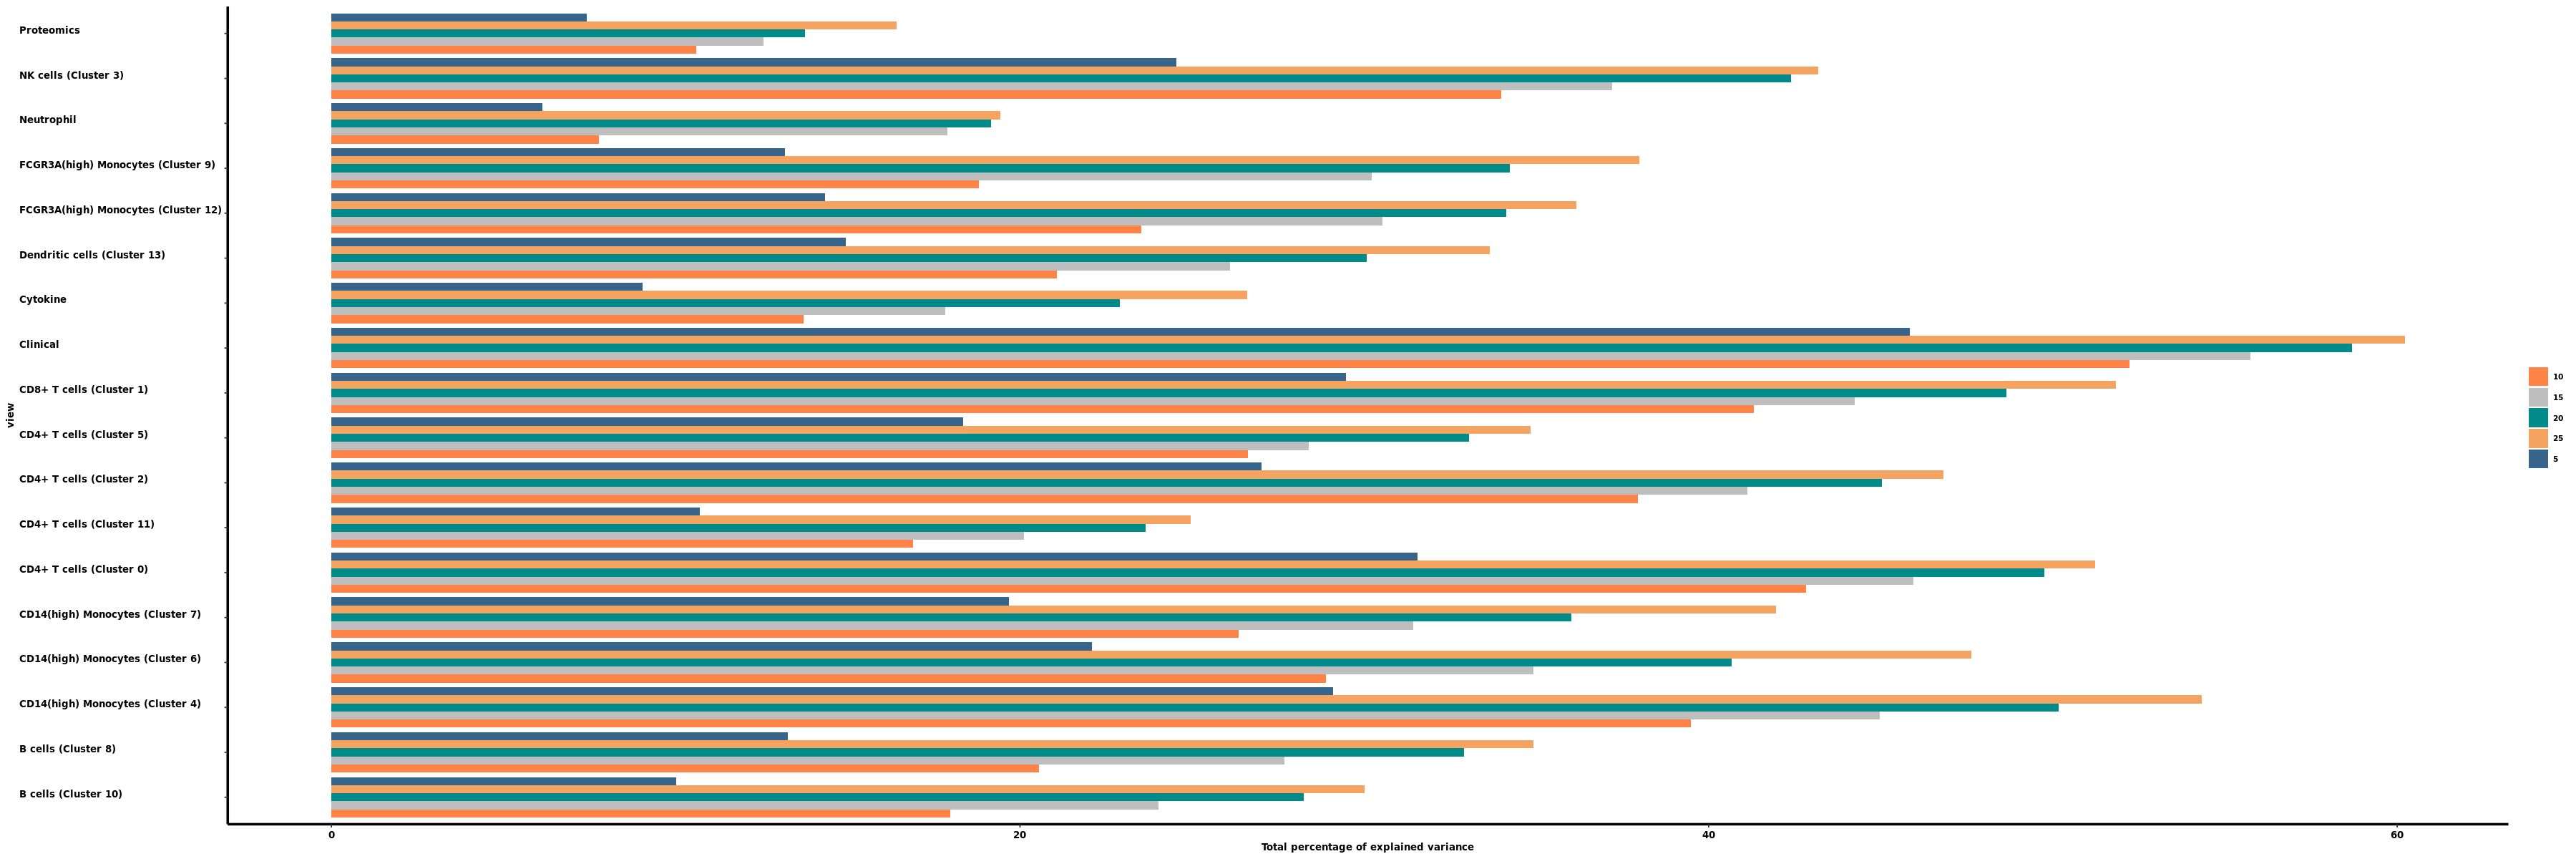

In [85]:
plot = ggplot(var_explained_per_view_data, aes(x=view, y=data, fill=amount_factors, order = as.numeric(amount_factors))) + 
    geom_bar(position="dodge", stat="identity") + ylab('amount_explained_variance') + plot_config +scale_fill_manual(
    values = c("sienna1", "grey", "cyan4", "sandybrown", "steelblue4") ) + coord_flip() + ylab('Total percentage of explained variance')
  

plot
pdf(paste0('figures/Supplementary_Figures/', figure_name, '.pdf'), width =width_par, height =height_par)
print( plot)
dev.off()

## Compare factor weights of samples

In [87]:
factor_weights = lapply(model_list, function(x){
    get_factors(x, factors = 'all')$group1
    })

In [88]:
factor_weight_data = data.frame()

for(i in names(factor_weights)){
    data = factor_weights[[i]]
    data = as.data.frame(data)
    data$amount_factors = i
    data$sample = rownames(data)
    data = melt(data)
    factor_weight_data = rbind(data, factor_weight_data)
    }

Warning message in melt(data):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data). In the next version, this warning will become an error.”
Using amount_factors, sample as id variables

Warning message in melt(data):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data). In the next version, this warning will become an error.”
Using amount_factors, sample as id variables

Wa

In [89]:
factor_weight_data$factor_amount = paste0(factor_weight_data$variable, '_', factor_weight_data$amount_factors)

In [90]:
head(factor_weight_data,2)

,amount_factors,sample,variable,value,factor_amount
,<chr>,<chr>,<fct>,<dbl>,<chr>
1,25,k1,Factor1,0.3492496,Factor1_25
2,25,k10,Factor1,0.9017081,Factor1_25


In [91]:
factor_weight_data = factor_weight_data[factor_weight_data$variable %in% c('Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5'),]

In [92]:
cor_data = factor_weight_data %>% dcast(sample ~ factor_amount, value.var = 'value')

Warning message in dcast(., sample ~ factor_amount, value.var = "value"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error.”


In [93]:
head(cor_data,2)

,sample,Factor1_10,Factor1_15,Factor1_20,Factor1_25,Factor1_5,Factor2_10,Factor2_15,Factor2_20,Factor2_25,⋯,Factor4_10,Factor4_15,Factor4_20,Factor4_25,Factor4_5,Factor5_10,Factor5_15,Factor5_20,Factor5_25,Factor5_5
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,k1,0.6256661,0.3770596,0.4811325,0.3492496,0.9879606,1.1655045,-0.2461713,-0.2731317,-0.4135044,⋯,0.6640261,-0.2214038,-0.4135678,-0.2262882,0.8420459,1.9680061,1.3636951,1.5052706,1.1603206,-2.516618
2,k10,0.9366665,0.9141488,0.8920603,0.9017081,1.0100067,-0.7416383,-0.7229450,-0.7547770,-0.7774918,⋯,-0.0740634,-0.1403714,-0.1524478,-0.2376890,-0.2809117,0.5079379,0.4718138,0.4074517,0.4962667,-1.205309


In [94]:
cor_data$sample = NULL
correlation = cor(cor_data)

In [95]:
head(correlation,2)

,Factor1_10,Factor1_15,Factor1_20,Factor1_25,Factor1_5,Factor2_10,Factor2_15,Factor2_20,Factor2_25,Factor2_5,⋯,Factor4_10,Factor4_15,Factor4_20,Factor4_25,Factor4_5,Factor5_10,Factor5_15,Factor5_20,Factor5_25,Factor5_5
Factor1_10,1.0000000,0.9972255,0.9966934,0.9943720,0.9958467,-0.04611233,-0.05657813,-0.03081553,-0.04354142,-0.02994066,⋯,0.01658558,-0.005101416,-0.014264936,-0.02084895,0.07690854,0.008162509,0.012619604,0.014253300,0.010784077,-0.10927773
Factor1_15,0.9972255,1.0000000,0.9982060,0.9967859,0.9914361,-0.04517258,-0.04058521,-0.01740064,-0.03151405,-0.02423510,⋯,0.01918224,0.003563360,-0.008299132,-0.01063121,0.07271472,0.001673007,0.006284571,0.004823152,0.002570033,-0.09947495


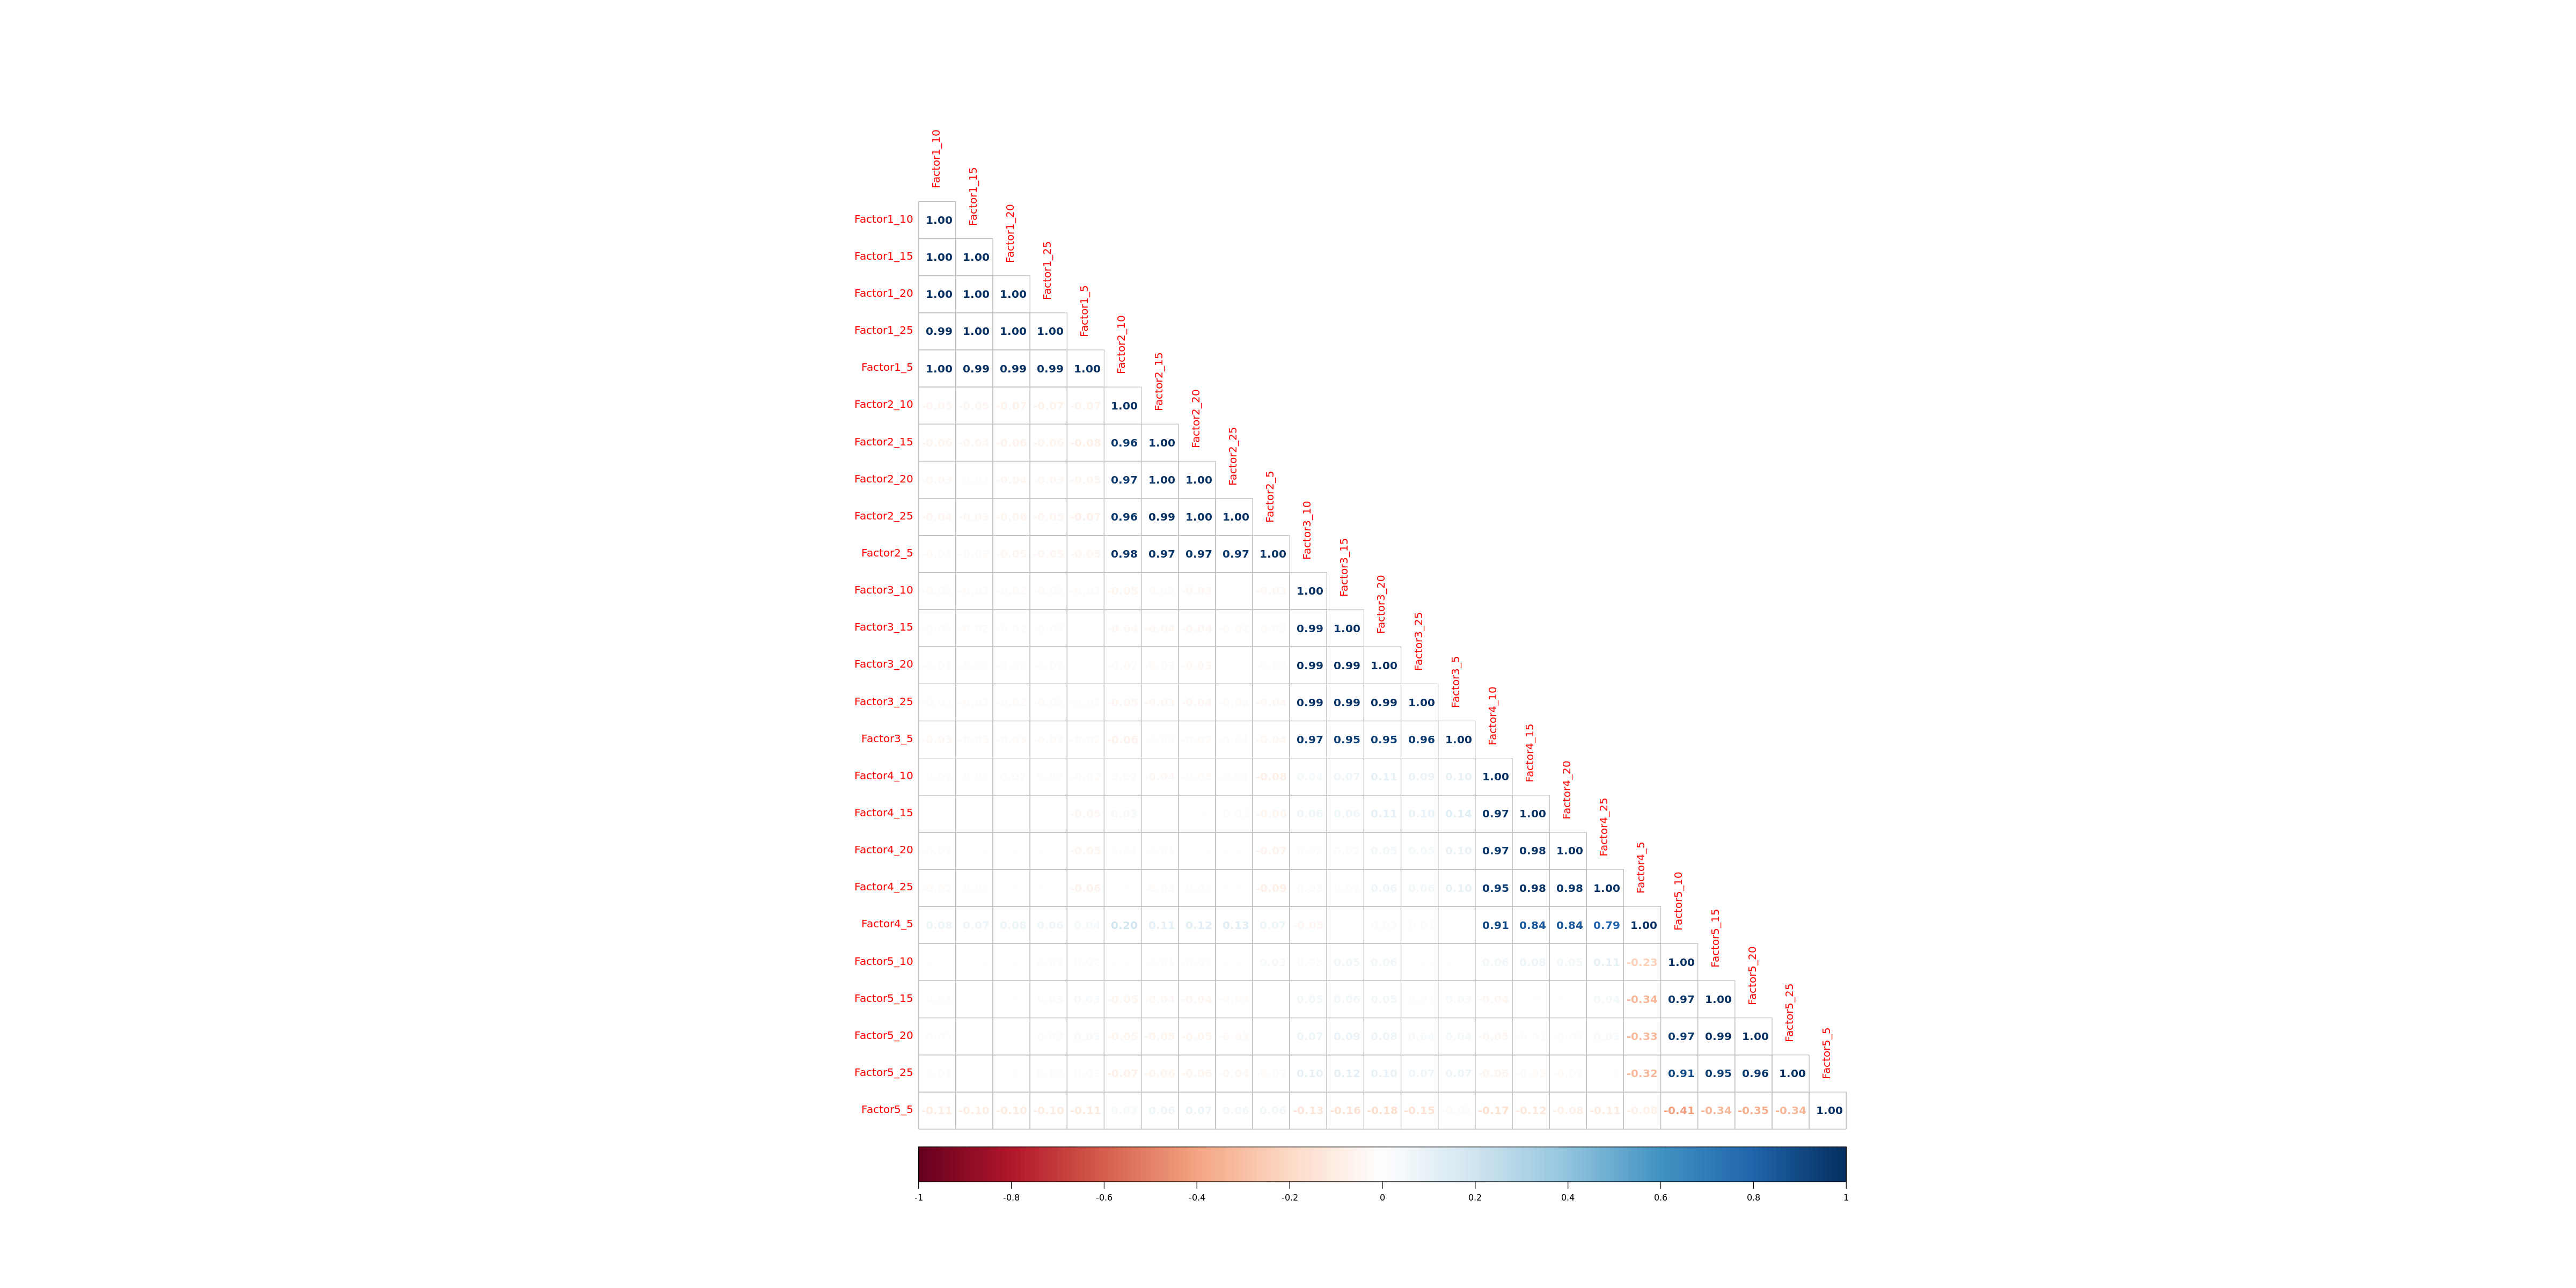

In [96]:
options(repr.plot.width=40, repr.plot.height=20)
corrplot(correlation, method = 'number',  type = 'lower')

In [97]:
### Filter matrix

correlation = correlation[!is.na(str_extract(rownames(correlation), '_20')),]
correlation = correlation[,is.na(str_extract(colnames(correlation), '_20'))]

In [98]:
correlation = melt(correlation)

Warning message in melt(correlation):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(correlation). In the next version, this warning will become an error.”


In [99]:
correlation$Factor_20 = str_replace(correlation$Var1, '_.*', '')
correlation$Factor  = str_replace(correlation$Var2, '_.*', '')

In [100]:
correlation = correlation[correlation$Factor_20 == correlation$Factor,]

In [101]:
correlation$Factor_20 = NULL
correlation$Factor = NULL
colnames(correlation) = c('Factor_AmountMOFAFactors', 'Factor_AlternativeAmountMOFAFactors', 'Pearson_Correlation_Factor_Values')
correlation$Pearson_Correlation_Factor_Values = round(correlation$Pearson_Correlation_Factor_Values, 2)

In [102]:
correlation 

,Factor_AmountMOFAFactors,Factor_AlternativeAmountMOFAFactors,Pearson_Correlation_Factor_Values
,<fct>,<fct>,<dbl>
1,Factor1_20,Factor1_10,1.00
6,Factor1_20,Factor1_15,1.00
11,Factor1_20,Factor1_25,1.00
16,Factor1_20,Factor1_5,0.99
22,Factor2_20,Factor2_10,0.97
27,Factor2_20,Factor2_15,1.00
32,Factor2_20,Factor2_25,1.00
37,Factor2_20,Factor2_5,0.97
43,Factor3_20,Factor3_10,0.99


In [103]:
factor_correlation = correlation

In [104]:
#head(correlation)

## Compare feature weights

In [105]:
weights = lapply(model_list, function(x){
    get_weights(x, views = "all", factors = "all")
    })

In [106]:
weight_data = data.frame()

In [107]:
for(j in names(weights)){
    weights_factor_amount = weights[[j]]

    for (i in names(weights_factor_amount)){
        data = data.frame(weights_factor_amount[[i]])
        data$view = i
        data$amount_factors = j
        data$feature = rownames(data)
        data = melt(data)
        weight_data = rbind(weight_data,data)
        }
    }

Warning message in melt(data):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data). In the next version, this warning will become an error.”
Using view, amount_factors, feature as id variables

Warning message in melt(data):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data). In the next version, this warning will become an error.”
Using view, amount_factors, feature as id

In [108]:
head(weight_data,2)

,view,amount_factors,feature,variable,value
,<chr>,<chr>,<chr>,<fct>,<dbl>
1,clinical_data,5,CK,Factor1,-0.16421525
2,clinical_data,5,CK_MB,Factor1,-0.08297461


In [109]:
weight_data$factor_amount = paste0(weight_data$variable, '_',weight_data$amount_factors)
weight_data$view_feature = paste0(weight_data$view, '__', weight_data$feature)

In [110]:
head(weight_data,2)

,view,amount_factors,feature,variable,value,factor_amount,view_feature
,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<chr>
1,clinical_data,5,CK,Factor1,-0.16421525,Factor1_5,clinical_data__CK
2,clinical_data,5,CK_MB,Factor1,-0.08297461,Factor1_5,clinical_data__CK_MB


In [111]:
weight_data = weight_data[weight_data$variable %in% c('Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5'),]

In [112]:
cor_data = weight_data %>% dcast(view_feature ~ factor_amount, value.var = 'value')

Warning message in dcast(., view_feature ~ factor_amount, value.var = "value"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error.”


In [113]:
head(cor_data,2)

,view_feature,Factor1_10,Factor1_15,Factor1_20,Factor1_25,Factor1_5,Factor2_10,Factor2_15,Factor2_20,Factor2_25,⋯,Factor4_10,Factor4_15,Factor4_20,Factor4_25,Factor4_5,Factor5_10,Factor5_15,Factor5_20,Factor5_25,Factor5_5
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,clinical_data__CK,-0.1293827,-0.13008322,-0.13418597,-0.13879716,-0.16421525,0.4261088,0.4103101,0.4019222,0.3990806,⋯,-0.01379236,0.0009803366,-0.002177566,-0.01107467,0.03227542,-0.5099953,-0.5241314,-0.5093667,-0.5228137,0.18486391
2,clinical_data__CK_MB,-0.0632572,-0.08102954,-0.06222621,-0.06819211,-0.08297461,0.3253176,0.2996687,0.2731985,0.3042624,⋯,-0.17713406,-0.0901101008,-0.076098327,-0.03504153,-0.04180807,-0.2535519,-0.1767650,-0.1439445,-0.2768709,0.09624404


In [114]:
cor_data$view_feature = NULL
correlation = cor(cor_data)

In [115]:
head(correlation,2)

,Factor1_10,Factor1_15,Factor1_20,Factor1_25,Factor1_5,Factor2_10,Factor2_15,Factor2_20,Factor2_25,Factor2_5,⋯,Factor4_10,Factor4_15,Factor4_20,Factor4_25,Factor4_5,Factor5_10,Factor5_15,Factor5_20,Factor5_25,Factor5_5
Factor1_10,1.0000000,0.9991992,0.9987107,0.9980179,0.9970633,-0.01815664,-0.01980683,0.005817692,-0.004442814,0.002565485,⋯,0.02902674,0.007480097,-0.001558749,-0.008954246,0.1070829,0.001094343,3.099911e-03,-0.003353694,-0.003319115,-0.1244498
Factor1_15,0.9991992,1.0000000,0.9988976,0.9978369,0.9953431,-0.01872129,-0.01967838,0.004842524,-0.005826318,0.001093841,⋯,0.03682047,0.014995756,0.004380620,-0.001741582,0.1137654,-0.001638296,-2.216957e-05,-0.007111609,-0.006114253,-0.1236148


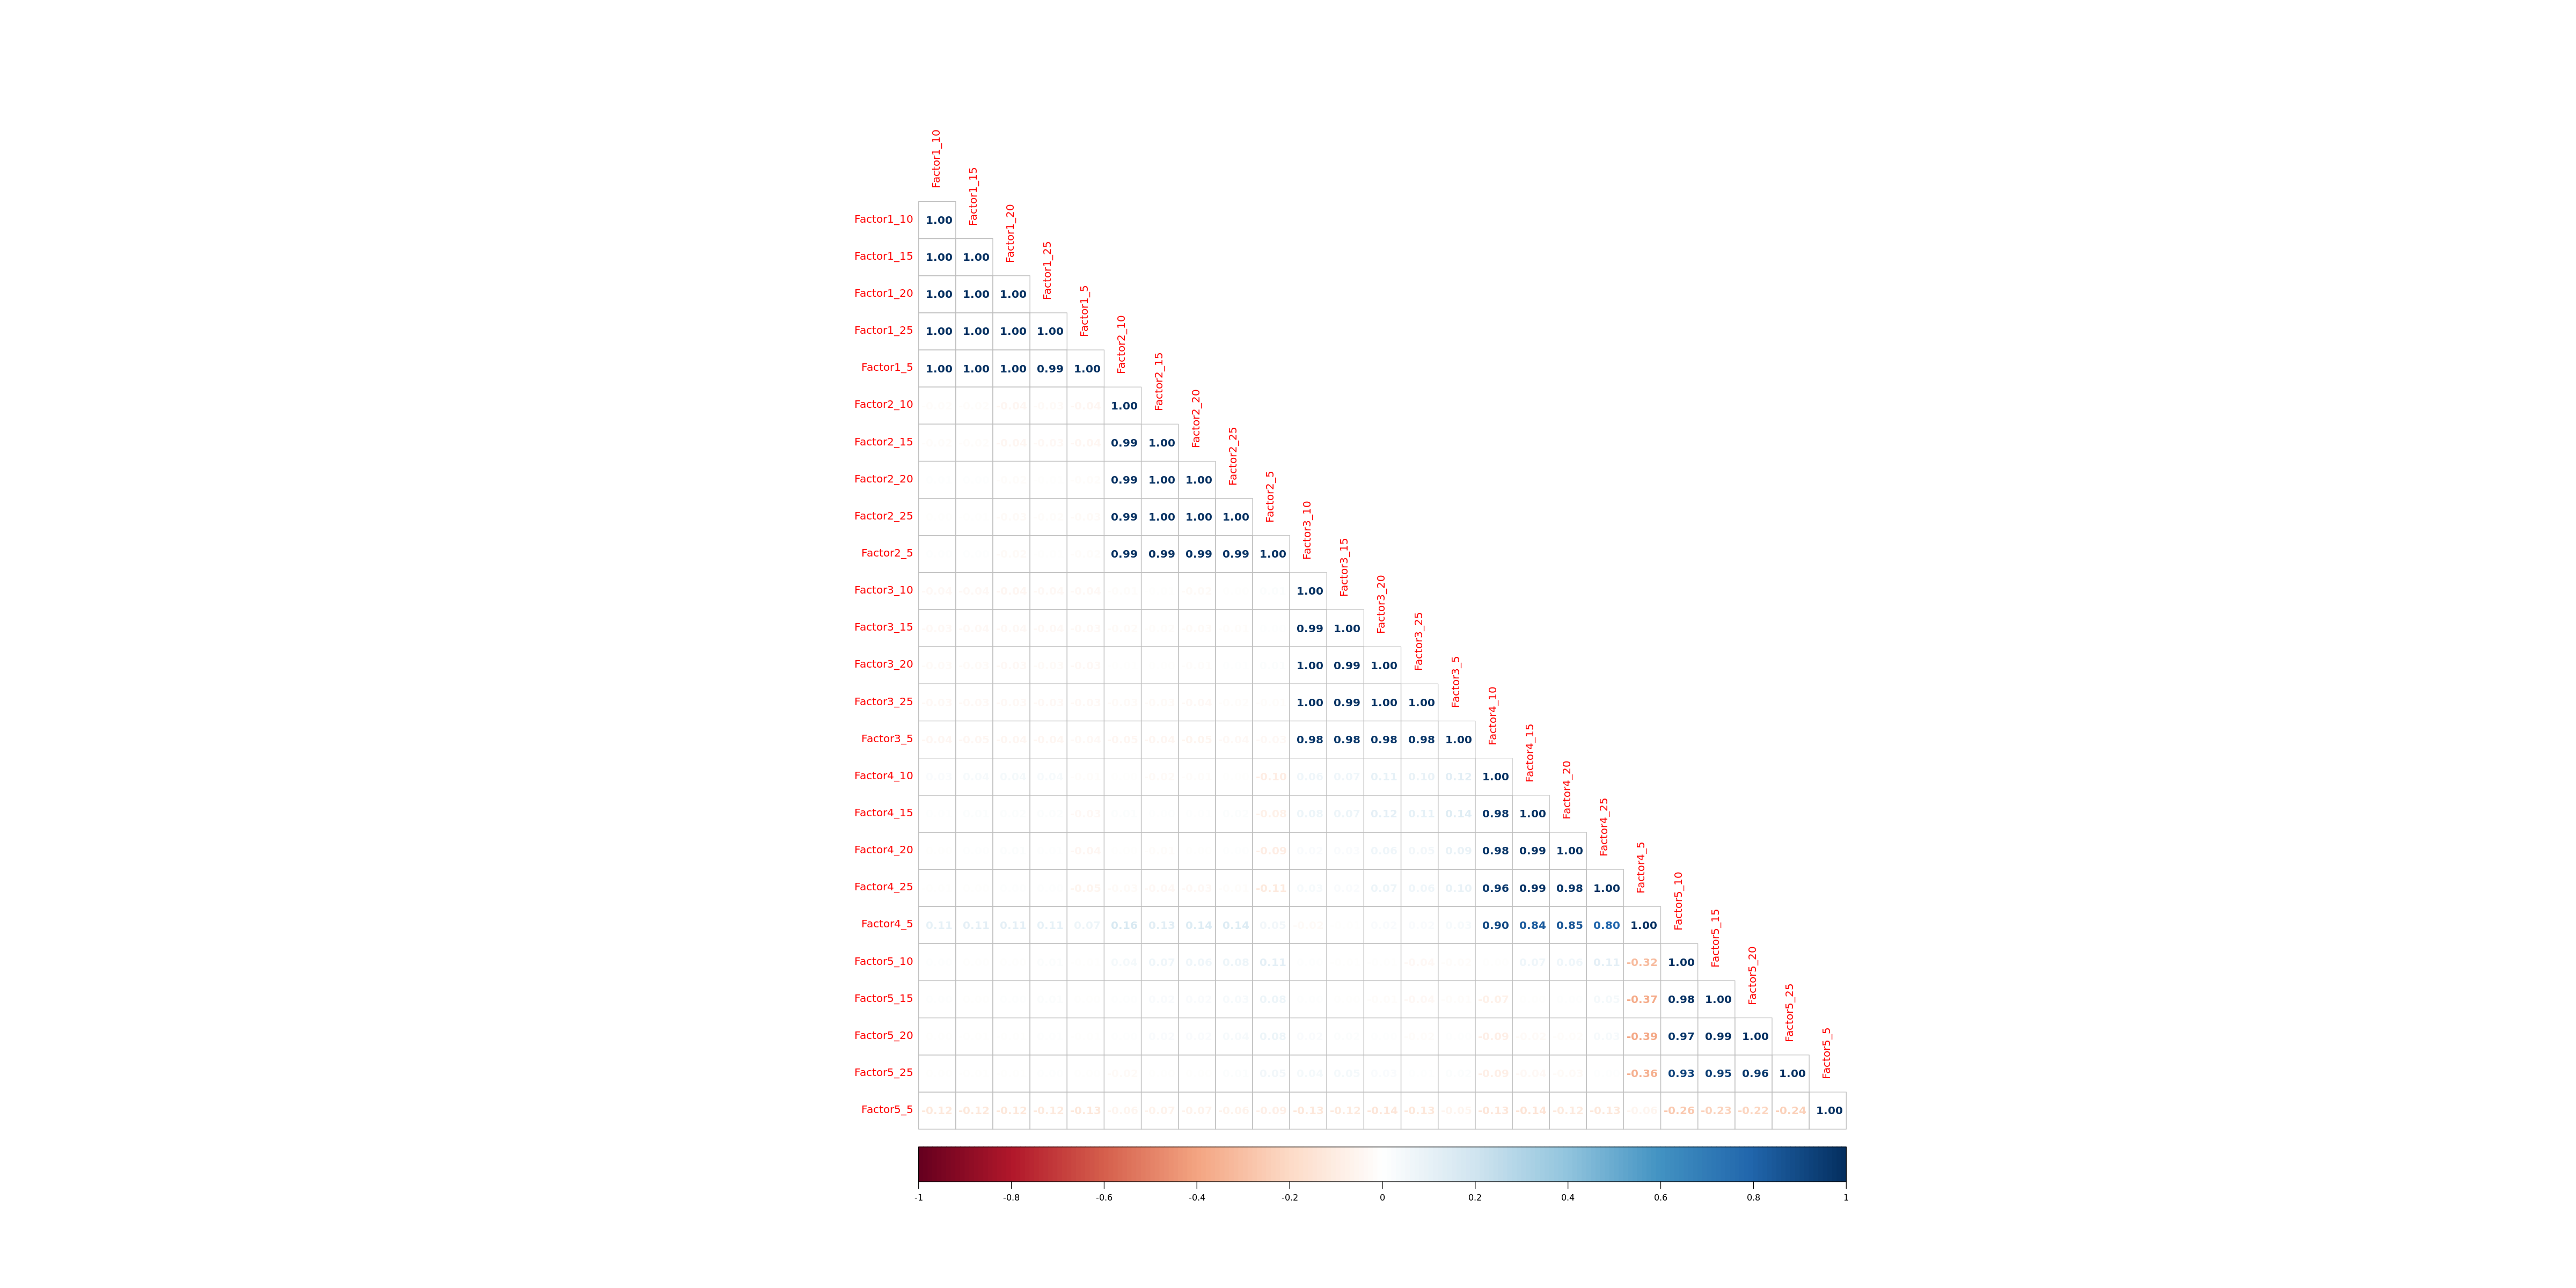

In [116]:
options(repr.plot.width=40, repr.plot.height=20)
corrplot(correlation, method = 'number',  type = 'lower')

In [117]:
### Filter matrix

correlation = correlation[!is.na(str_extract(rownames(correlation), '_20')),]
correlation = correlation[,is.na(str_extract(colnames(correlation), '_20'))]

In [118]:
correlation = melt(correlation)

Warning message in melt(correlation):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(correlation). In the next version, this warning will become an error.”


In [119]:
correlation$Factor_20 = str_replace(correlation$Var1, '_.*', '')
correlation$Factor  = str_replace(correlation$Var2, '_.*', '')

In [120]:
correlation = correlation[correlation$Factor_20 == correlation$Factor,]

In [121]:
correlation$Factor_20 = NULL
correlation$Factor = NULL
colnames(correlation) = c('Factor_AmountMOFAFactors', 'Factor_AlternativeAmountMOFAFactors', 'Pearson_Correlation_Feature_Weights')
correlation$Pearson_Correlation_Feature_Weights = round(correlation$Pearson_Correlation_Feature_Weights, 2)

In [122]:
correlation 

,Factor_AmountMOFAFactors,Factor_AlternativeAmountMOFAFactors,Pearson_Correlation_Feature_Weights
,<fct>,<fct>,<dbl>
1,Factor1_20,Factor1_10,1.00
6,Factor1_20,Factor1_15,1.00
11,Factor1_20,Factor1_25,1.00
16,Factor1_20,Factor1_5,1.00
22,Factor2_20,Factor2_10,0.99
27,Factor2_20,Factor2_15,1.00
32,Factor2_20,Factor2_25,1.00
37,Factor2_20,Factor2_5,0.99
43,Factor3_20,Factor3_10,1.00


In [123]:
correlation = merge(factor_correlation, correlation)

In [124]:
write.csv(correlation, paste0(result_path, 'Supplementary/SUPP_E5_Correlation_MOFA_Diff_Amount_Factors.csv'))

In [125]:
correlation

Factor_AmountMOFAFactors,Factor_AlternativeAmountMOFAFactors,Pearson_Correlation_Factor_Values,Pearson_Correlation_Feature_Weights
<fct>,<fct>,<dbl>,<dbl>
Factor1_20,Factor1_10,1.00,1.00
Factor1_20,Factor1_15,1.00,1.00
Factor1_20,Factor1_25,1.00,1.00
Factor1_20,Factor1_5,0.99,1.00
Factor2_20,Factor2_10,0.97,0.99
Factor2_20,Factor2_15,1.00,1.00
Factor2_20,Factor2_25,1.00,1.00
Factor2_20,Factor2_5,0.97,0.99
Factor3_20,Factor3_10,0.99,1.00
